# Galaxy Zoo

**Nombre** Lautaro Marin

**Contacto:** marinlauti00@gmail.com

Se utilizaron datos de Galaxy Zoo para identificar aquellas galaxias que sean elípticas a partir de sus características físicas. Se realizó exploración y limpieza de los datos y se realizó la clasificación haciendo uso de una red neuronal de 3 capas. Luego, se evaluó el rendimiento del modelo.

In [4]:
#Importo las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


plt.style.use('seaborn-v0_8-darkgrid')

In [5]:

#%%
# Cargo los datos
df_galaxias = pd.read_csv('galaxy_morphology_labeled.csv')


df = df_galaxias.copy()


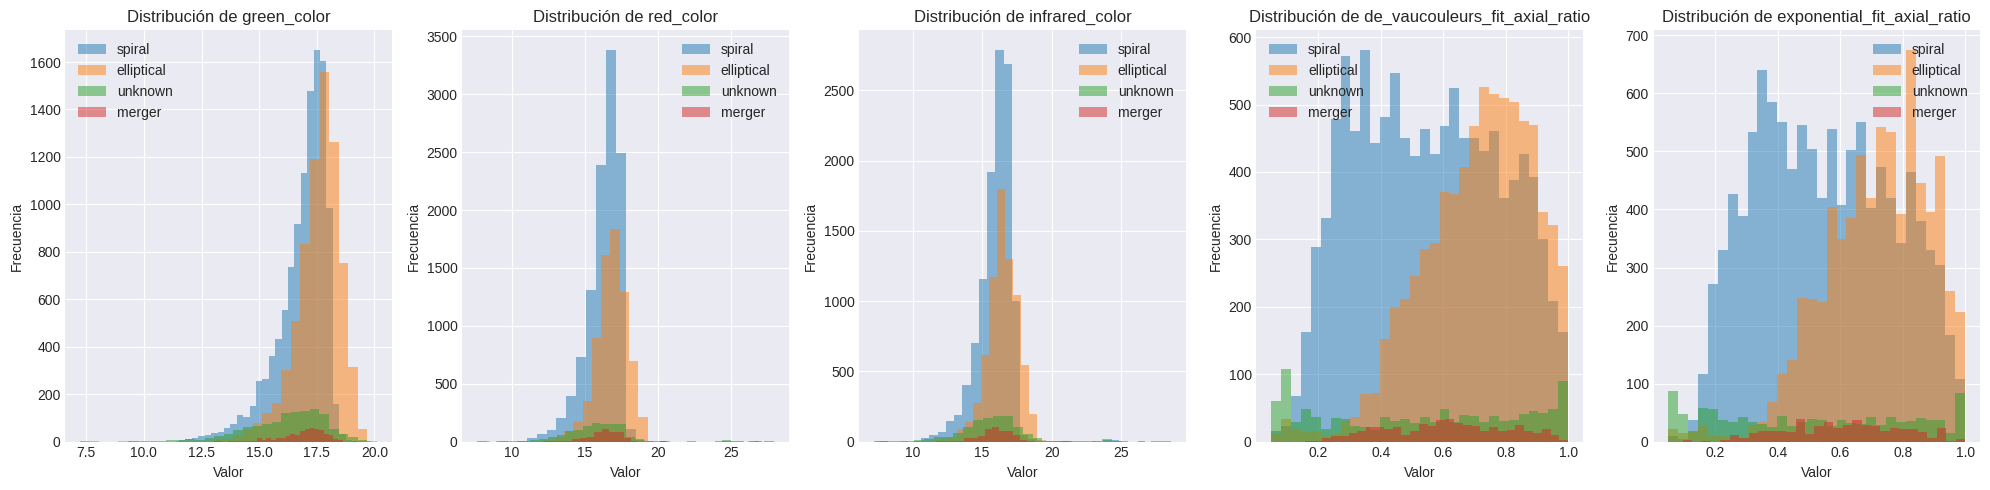

In [6]:
#%%
#Grafico los histogramas para las variables físicas


colores = ['green_color', 'red_color', 'infrared_color']
variables_forma = ['de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio']

clases = df['class'].unique()

# Colores y formas en histogramas separados
fig, axs = plt.subplots(1, len(colores) + len(variables_forma), figsize=(20,5))

for i, var in enumerate(colores + variables_forma):
    ax = axs[i]
    for clase in clases:
        datos = df[df['class'] == clase][var]
        ax.hist(datos, bins=30, alpha=0.5, label=clase)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.legend()

plt.tight_layout()
plt.show()

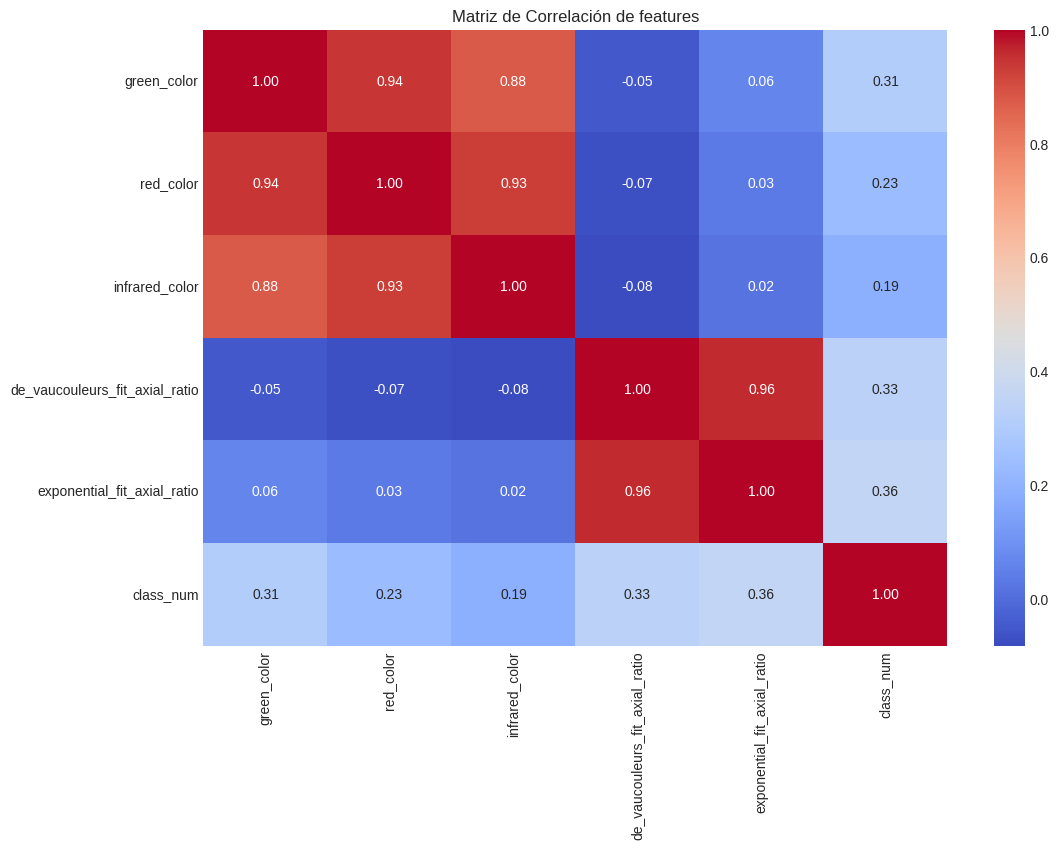


Correlación de variables con clase elíptica (class_num):
class_num                         1.000000
exponential_fit_axial_ratio       0.360315
de_vaucouleurs_fit_axial_ratio    0.332436
green_color                       0.308912
red_color                         0.234151
infrared_color                    0.191797
Name: class_num, dtype: float64


In [7]:
#%%
#Armo la matriz de correlación

# Codifico las clases (elíptica=1, no elíptica=0)
df['class_num'] = (df['class'] == 'elliptical').astype(int)

# Nuevamente, no uso ni los votos, ni las variables de likelihood, ni las de probabilidad
cols_drop = ['exponential_disc_fit_log_likelihood', 'de_vaucouleurs_fit_log_likelihood',
             'star_log_likelihood', 'number_of_votes', 'probability_elliptical',
             'probability_spiral', 'probability_unknown', 'probability_merger', 'class']

df_corr = df.drop(columns=cols_drop)


corr_matrix = df_corr.corr()

#con heatmap:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de features')
plt.show()


print("\nCorrelación de variables con clase elíptica (class_num):")
corr_class = corr_matrix['class_num'].sort_values(ascending=False)
print(corr_class)


In [8]:

#%%
# Remuevo los outliers

def remover_outliers(df, columna):
    media = df[columna].mean()
    std = df[columna].std()
    lim_inf = media - 3*std
    lim_sup = media + 3*std
    df_filtrado = df[(df[columna] >= lim_inf) & (df[columna] <= lim_sup)]
    return df_filtrado

# Aplico para cada banda de color
df_no_outliers_1 = remover_outliers(df, 'green_color')
df_no_outliers_2 = remover_outliers(df, 'red_color')
df_no_outliers_3 = remover_outliers(df, 'infrared_color')

# Intersección
indices_comunes = df_no_outliers_1.index.intersection(df_no_outliers_2.index).intersection(df_no_outliers_3.index)
df_sin_outliers = df.loc[indices_comunes].copy()

print(f"Datos originales: {len(df)}")
print(f"Datos después de remover outliers: {len(df_sin_outliers)}")
print(f"Datos eliminados: {len(df) - len(df_sin_outliers)}")



Datos originales: 20170
Datos después de remover outliers: 19758
Datos eliminados: 412


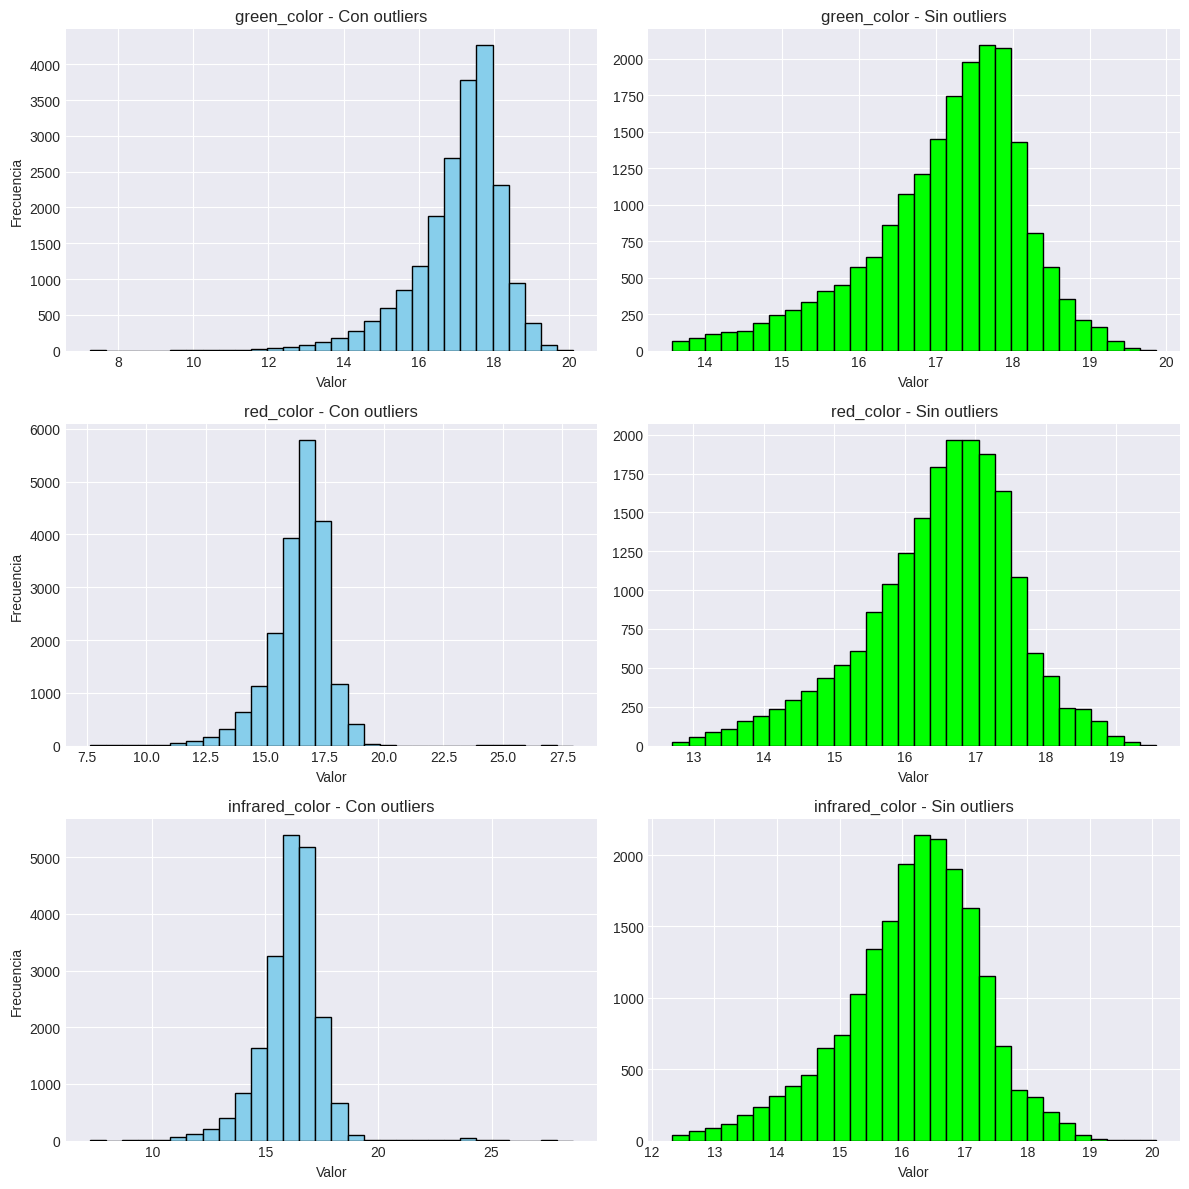

In [9]:
#%%
# Distribuciones con y sin outliers en bandas de colores

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

bandas = ['green_color', 'red_color', 'infrared_color']

for i, banda in enumerate(bandas):
    axs[i, 0].hist(df[banda], bins=30, color='skyblue', edgecolor='k')
    axs[i, 0].set_title(f'{banda} - Con outliers')
    axs[i, 0].set_xlabel('Valor')
    axs[i, 0].set_ylabel('Frecuencia')

    axs[i, 1].hist(df_sin_outliers[banda], bins=30, color='lime', edgecolor='k')
    axs[i, 1].set_title(f'{banda} - Sin outliers')
    axs[i, 1].set_xlabel('Valor')

plt.tight_layout()
plt.show()



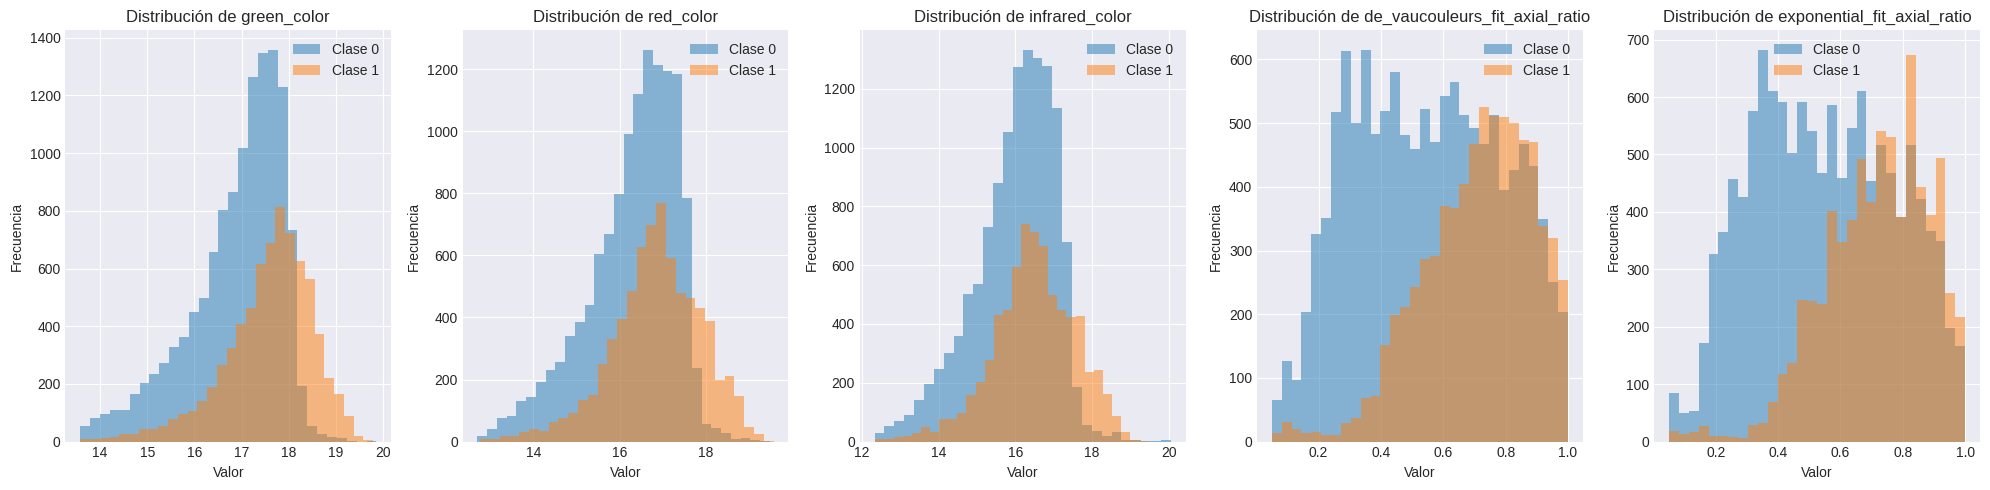

Las distribuciones muestran separación, pero algunas variables se solapan mucho. Podría no ser suficiente para distinguir todas las galaxias elípticas.


In [10]:
#%%
# Veo los histogramas de atributos principales en df_sin_outliers para ver si hay separación

colores = ['green_color', 'red_color', 'infrared_color']
variables_forma = ['de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio']

fig, axs = plt.subplots(1, len(colores) + len(variables_forma), figsize=(20,5))

for i, var in enumerate(colores + variables_forma):
    ax = axs[i]
    for clase in df_sin_outliers['class_num'].unique():
        datos = df_sin_outliers[df_sin_outliers['class_num'] == clase][var]
        ax.hist(datos, bins=30, alpha=0.5, label=f'Clase {clase}')
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.legend()

plt.tight_layout()
plt.show()

print("Las distribuciones muestran separación, pero algunas variables se solapan mucho. Podría no ser suficiente para distinguir todas las galaxias elípticas.")



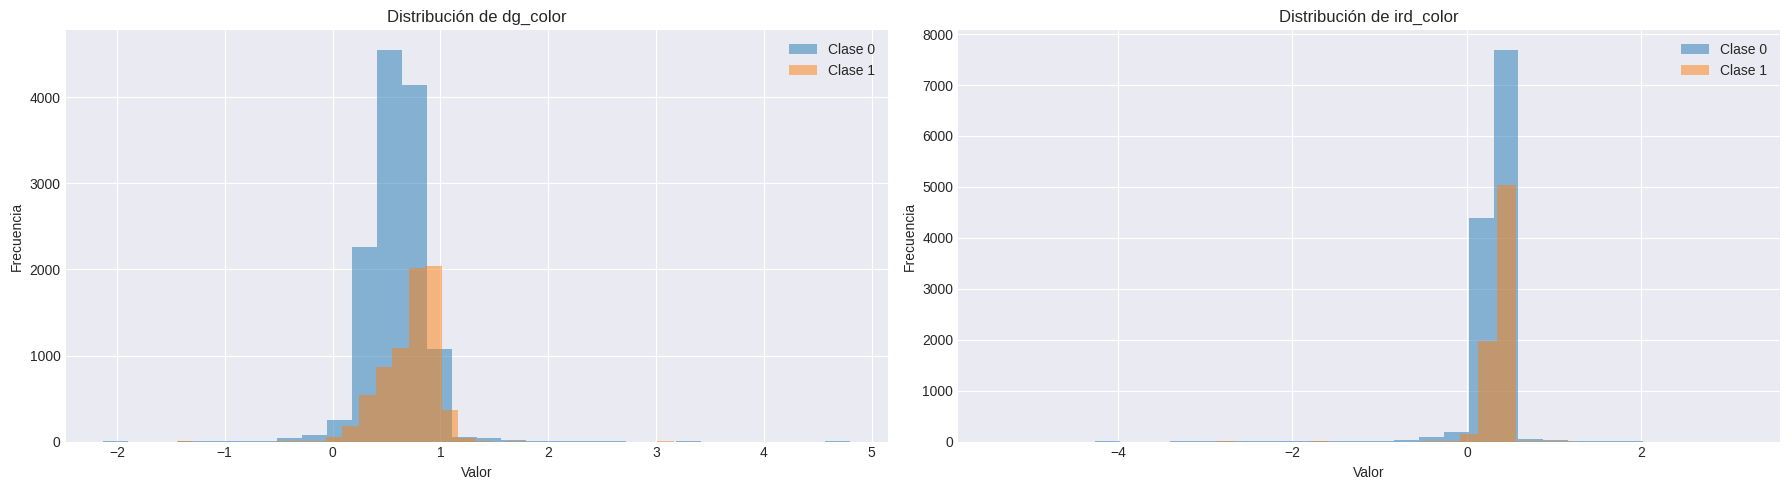

Se ven diferencias claras para dg_color, pero muy escasas para ird_color. Aún así, no descarto esta última feature.


In [11]:
#%%
# Creo tres nuevas features

df_sin_outliers['dg_color'] = df_sin_outliers['green_color'] - df_sin_outliers['red_color']
df_sin_outliers['ird_color'] = df_sin_outliers['red_color'] - df_sin_outliers['infrared_color']


# las visualizo
nuevos_atributos = ['dg_color', 'ird_color']

fig, axs = plt.subplots(1, len(nuevos_atributos), figsize=(18,5))

for i, var in enumerate(nuevos_atributos):
    ax = axs[i]
    for clase in df_sin_outliers['class_num'].unique():
        datos = df_sin_outliers[df_sin_outliers['class_num'] == clase][var]
        ax.hist(datos, bins=30, alpha=0.5, label=f'Clase {clase}')
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.legend()

plt.tight_layout()
plt.show()

print("Se ven diferencias claras para dg_color, pero muy escasas para ird_color. Aún así, no descarto esta última feature.")

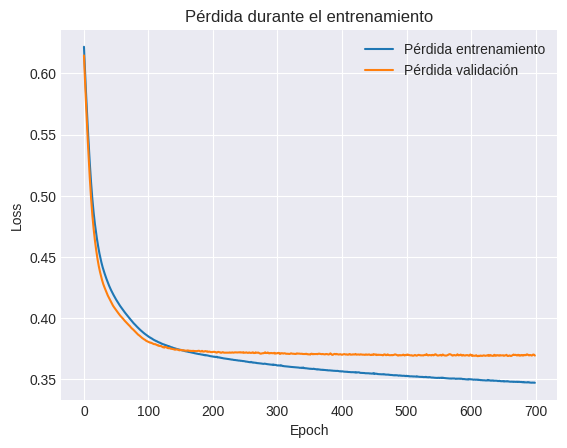

In [12]:
#%%

# Selecciono los atributos
atributos = ['green_color', 'red_color', 'infrared_color', 'de_vaucouleurs_fit_axial_ratio',
             'exponential_fit_axial_ratio', 'dg_color', 'ird_color']

X = df_sin_outliers[atributos]
y = df_sin_outliers['class_num']

# Normalizo
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Divido los datos
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)


from tensorflow.keras.layers import Input

def crear_modelo_baseline(input_dim, num_nodes=20):
    modelo = Sequential()
    modelo.add(Input(shape=(input_dim,))) # Use Input layer for specifying input shape
    modelo.add(Dense(num_nodes, activation='relu')) # No input_dim needed here
    modelo.add(Dense(num_nodes, activation='relu'))
    modelo.add(Dense(num_nodes, activation='relu'))
    modelo.add(Dense(1, activation='sigmoid'))
    modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return modelo

modelo = crear_modelo_baseline(input_dim=X_train.shape[1])


history = modelo.fit(X_train, y_train,
                     batch_size=5000,
                     epochs=700,
                     validation_split=0.2,
                     shuffle=True,
                     verbose=0)

# Grafico
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2500
           1       0.79      0.78      0.78      1452

    accuracy                           0.84      3952
   macro avg       0.83      0.83      0.83      3952
weighted avg       0.84      0.84      0.84      3952



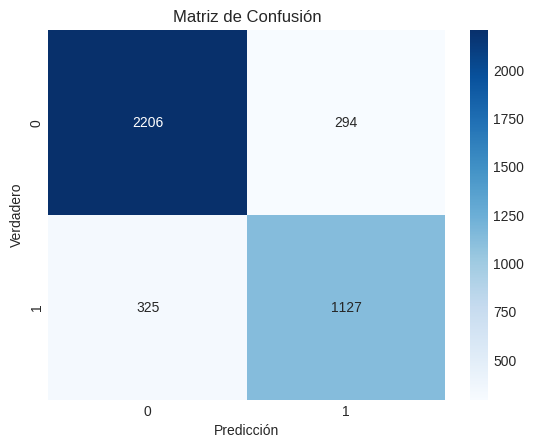

In [13]:
#%%
# Evaluación del modelo


y_pred_prob = modelo.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()



### Exploración de Datos Adicional y Observaciones

Después de cargar los datos, se realizó una exploración inicial para observar la distribución de las variables y la relación entre ellas.

Los histogramas de las bandas de color (`green_color`, `red_color`, `infrared_color`) muestran una distribución que varía entre las diferentes clases. En particular, se observan diferencias notables en la distribución de `green_color` entre galaxias elípticas (clase 1) y otras clases (clase 0), lo que sugiere que esta característica podría ser importante para la clasificación.

Por otro lado, las variables (`de_vaucouleurs_fit_axial_ratio` y `exponential_fit_axial_ratio`) también muestran diferencias en sus distribuciones entre las clases, especialmente para las galaxias elípticas, que tienden a tener valores de axial ratio más altos.


### Ingeniería de Features

Basado en la exploración inicial, se decidió crear dos nuevas features combinando las bandas de color:

*   `dg_color`: Diferencia entre `green_color` y `red_color`. La hipótesis es que la diferencia en la intensidad de luz en estas bandas podría ser distintiva para diferentes tipos de galaxias.
*   `ird_color`: Diferencia entre `red_color` e `infrared_color`.

Al visualizar la distribución de estas nuevas features por clase, se observa que `dg_color` muestra una separación más clara entre las galaxias elípticas (clase 1) y las otras clases (clase 0) en comparación con `ird_color`. Aunque `ird_color` no muestra una separación tan marcada, se decidió incluirla inicialmente en el modelo para ver si aportaba información útil.

### Evaluación del Modelo

Se evaluó el rendimiento del modelo en el conjunto de datos de prueba utilizando un reporte de clasificación y una matriz de confusión.

Específicamente, se obtuvo:

*   **Precision:** De todas las galaxias que el modelo predijo como elípticas (clase 1), el 78% fueron realmente elípticas. Para las galaxias no elípticas (clase 0), el 87% de las predicciones fueron correctas.
*   **Recall (Sensibilidad):** De todas las galaxias que son realmente elípticas (clase 1), el modelo identificó correctamente el 78%. Para las galaxias no elípticas (clase 0), el modelo identificó correctamente el 87%.
*   **F1-score:** Es la media armónica de precision y recall, proporcionando un balance entre ambas métricas. Los F1-scores son 0.87 para la clase 0 y 0.78 para la clase 1.
*   **Accuracy:** La precisión general del modelo es del 84%, lo que significa que el 84% de todas las prediculas fueron correctas.

La **matriz de confusión** nos da una visión más detallada de los resultados:

*   **Verdaderos Positivos (True Positives - TP):** 1128 galaxias elípticas fueron correctamente identificadas como elípticas.
*   **Verdaderos Negativos (True Negatives - TN):** 2183 galaxias no elípticas fueron correctamente identificadas como no elípticas.
*   **Falsos Positivos (False Positives - FP):** 317 galaxias no elípticas fueron incorrectamente identificadas como elípticas (Errores de Tipo I).
*   **Falsos Negativos (False Negatives - FN):** 324 galaxias elípticas fueron incorrectamente identificadas como no elípticas (Errores de Tipo II).

Los resultados muestran que el modelo tiene un buen rendimiento general (84% de accuracy). Es ligeramente mejor prediciendo la clase 0 (no elípticas) que la clase 1 (elípticas), como se refleja en las métricas de precision y recall. La cantidad de falsos positivos y falsos negativos es similar, lo que indica que el modelo comete errores de clasificación en ambas direcciones en una medida parecida.

Dependiendo de la aplicación, podríamos querer optimizar para precision o recall. Por ejemplo, si fuera crucial identificar *todas* las galaxias elípticas posibles (alta recall para la clase 1), podríamos necesitar ajustar el umbral de clasificación o explorar otras técnicas.

### Conclusiones

En este proyecto, se clasificaron galaxias en base a sus características físicas utilizando una red neuronal simple. Se realizó la exploración de datos, manejo de outliers, ingeniería de features básicas y entrenamiento de un modelo de clasificación binaria.

El modelo alcanzó una precisión del 84% en el conjunto de prueba y demostró una capacidad razonable para distinguir entre galaxias elípticas y no elípticas. Las distribuciones de las bandas de color y las variables de axial ratio, así como la feature de ingeniería `dg_color`, resultaron ser informativas para la clasificación.

Para futuros trabajos, se podría considerar:

*   Experimentar con diferentes arquitecturas de red neuronal o modelos de clasificación.
*   Realizar una selección de features más rigurosa.
*   Abordar formalmente el posible desbalance de clases si la distribución de galaxias elípticas vs. no elípticas en el dataset completo lo requiere.
*   Realizar una validación cruzada para obtener una estimación más robusta del rendimiento del modelo.

Este proyecto demuestra los pasos fundamentales en un flujo de trabajo de machine learning, desde la exploración de datos hasta la evaluación del modelo.